### Train NNs on the toy example

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn.model_selection import train_test_split
import dama as dm
import pickle
import os

from freedom.toy_model.toy_model_functions import toy_model
from freedom.toy_model.detectors import get_box_detector
from types import SimpleNamespace
#from toy_NN_trafo import build_q_trafo, build_h_trafo

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [3]:
detector = get_box_detector(x=np.linspace(-5,5,5), y=[0,], z=[0,])

In [4]:
toy_experiment = toy_model(detector)

In [5]:
truth = np.array([1., 1, 0, 0, 0, 0, 1, 1])

In [6]:
# generate one test event
test_event = toy_experiment.generate_event(truth)

In [7]:
test_event[1]

array([0., 2., 7., 1., 2.])

In [8]:
%%time
# Grid scan

g = dm.GridData(x=np.linspace(-5, 5, 100), y=np.linspace(0, 2, 100))

g['dom_hit_term'] = np.empty(g.shape)
g['dom_charge_terms'] = np.empty(g.shape)
g['total_charge_hit_terms'] = np.empty(g.shape)
g['total_charge_terms'] = np.empty(g.shape)

p = np.copy(truth)

for idx in np.ndindex(g.shape):
    p[0] =  g['x'][idx]
    p[1] =  g['y'][idx]
    segments = toy_experiment.model(*p)
    g['dom_hit_term'][idx] = toy_experiment.nllh_p_term_dom(segments, test_event[0])
    g['dom_charge_terms'][idx] = toy_experiment.nllh_N_term_dom(segments, test_event[1])
    g['total_charge_hit_terms'][idx] = toy_experiment.nllh_p_term_tot(segments, test_event[0])
    g['total_charge_terms'][idx] = toy_experiment.nllh_N_term_tot(segments, test_event[1])

CPU times: user 20.9 s, sys: 0 ns, total: 20.9 s
Wall time: 20.9 s


In [9]:
g['dom_hit_term'] -= g['dom_hit_term'].min()
g['dom_charge_terms'] -= g['dom_charge_terms'].min()
g['dom_llh'] = g['dom_hit_term'] + g['dom_charge_terms']
g['total_charge_hit_terms'] -= g['total_charge_hit_terms'].min()
g['total_charge_terms'] -= g['total_charge_terms'].min()
g['total_charge_llh'] = g['total_charge_hit_terms'] + g['total_charge_terms']
g['dom_llh'] -= g['dom_llh'].min()
g['total_charge_llh'] -= g['total_charge_llh'].min()

In [10]:
def plot_truth(axes, truth):
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax in axes.flatten():
        ax.plot([truth[0]], [truth[1]], marker='$T$', markersize=10, color='k')

In [193]:
def plot_diff(a, b, axes, title_a='a', title_b='b', vmax=None, limit_diff=False, **kwargs):
    
    levels = stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2    
    labels = [str(i) + r'$\sigma$' for i in range(1,6)]
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    colors = plt.cm.viridis(np.linspace(0, 0.9, 6))
    a.plot(ax=axes[0], cmap='Greys', label=r'$\Delta LLH$', **kwargs)
    a.plot_contour(ax=axes[0], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
    axes[0].set_title(title_a)
    b.plot(ax=axes[1], cmap='Greys', label=r'$\Delta LLH$', **kwargs)
    b.plot_contour(ax=axes[1], levels=levels,  labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
    axes[1].set_title(title_b)
    diff = a - b
    if limit_diff:
        diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-vmax, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
        #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
        #np.clip(-diff, 0, None).plot_contour(ax=axes[2], levels=[0.1,0.2, 0.3], colors=['r']*2)
    else:
        diff.plot(ax=axes[2], cmap='RdBu', cbar=True, vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)), label=r'$\Delta LLH$', **kwargs) 
        #diff.plot_contour(ax=axes[2], levels=levels, labels=labels, colors=colors, label=r'$\Delta LLH$', **kwargs)
    axes[2].set_title(title_a + ' - ' + title_b)

In [12]:
#stats.norm.isf(stats.chi2(df=2).sf(g['dom_llh']*2)/2)

/tf/localscratch/weldert/dama/dama/plotting/stat_plot.py:482: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(X, Y, data, **kwargs)


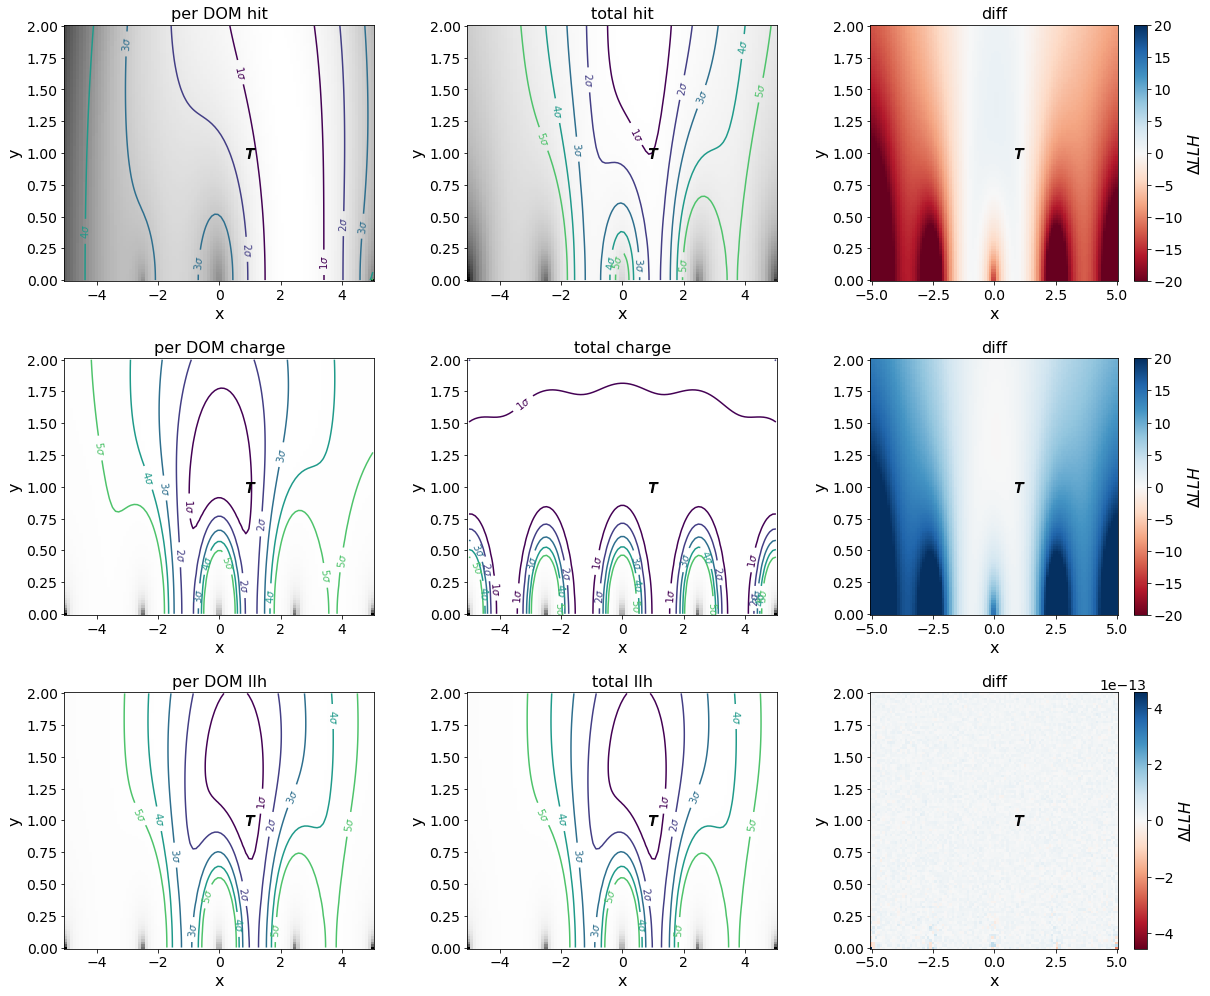

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(20,17))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

plot_diff(g['dom_hit_term'], g['total_charge_hit_terms'], axes=ax[0], title_a='per DOM hit', title_b='total hit', vmax=20, limit_diff=True)
plot_diff(g['dom_charge_terms'], g['total_charge_terms'], axes=ax[1], title_a='per DOM charge', title_b='total charge', vmax=20, limit_diff=True)
plot_diff(g['dom_llh'], g['total_charge_llh'], axes=ax[2], title_a='per DOM llh', title_b='total llh', limit_diff=False)

plot_truth(ax, truth)

In [14]:
stats.chi2(df=2).isf(stats.norm.sf(np.arange(1,6))*2)/2

array([ 1.14787446,  3.09003715,  5.91457904,  9.66695431, 14.37185121])

# Train NNs

In [15]:
from freedom.toy_model import NNs
%aimport freedom.toy_model.NNs

In [64]:
events, truths = toy_experiment.generate_event_box(n=100_000, e_lim=(1,5), x_lim=(-5,5), y_lim=(0, 2), z_lim=(0,0), inelast_lim=(0,0), t_width=0, contained=True)

100%|██████████| 100000/100000 [01:06<00:00, 1496.06it/s]


## Hit Net

In [219]:
x, t = NNs.get_hit_data(events, truths)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)
d_train = NNs.DataGenerator(x_train, t_train, batch_size=4096)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=4096)

In [220]:
optimizer = tf.keras.optimizers.Adam(5e-5)

hmodel = NNs.get_hmodel(x_shape=7, t_shape=8, trafo=NNs.hit_trafo, activation='swish')

hmodel.compile(loss='binary_crossentropy', optimizer=optimizer)

In [221]:
hist = hmodel.fit(d_train, epochs=15, verbose=1, validation_data=d_valid)

Epoch 1/15
1953/1953 [==============================] - 22s 11ms/step - loss: 0.4448 - val_loss: 0.4289
Epoch 2/15
1953/1953 [==============================] - 22s 11ms/step - loss: 0.4259 - val_loss: 0.4241
Epoch 3/15
1953/1953 [==============================] - 22s 11ms/step - loss: 0.4226 - val_loss: 0.4208
Epoch 4/15
1953/1953 [==============================] - 23s 12ms/step - loss: 0.4208 - val_loss: 0.4195
Epoch 5/15
1953/1953 [==============================] - 23s 12ms/step - loss: 0.4190 - val_loss: 0.4188
Epoch 6/15
1953/1953 [==============================] - 23s 12ms/step - loss: 0.4173 - val_loss: 0.4175
Epoch 7/15
1953/1953 [==============================] - 23s 12ms/step - loss: 0.4161 - val_loss: 0.4158
Epoch 8/15
1953/1953 [==============================] - 23s 12ms/step - loss: 0.4155 - val_loss: 0.4167
Epoch 9/15
1953/1953 [==============================] - 23s 12ms/step - loss: 0.4155 - val_loss: 0.4160
Epoch 10/15
1953/1953 [==============================] - 23s 12m

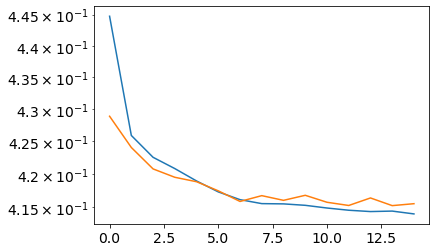

In [222]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

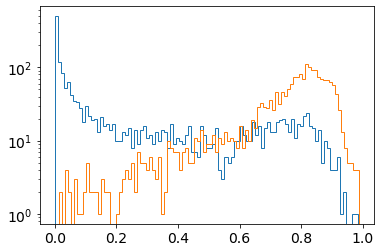

In [223]:
inp, lab = d_valid.__getitem__(0)
pred = hmodel.predict(inp, batch_size=4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

/tf/localscratch/weldert/dama/dama/plotting/stat_plot.py:482: UserWarning: The following kwargs were not used by contour: 'label'
  cs = ax.contour(X, Y, data, **kwargs)


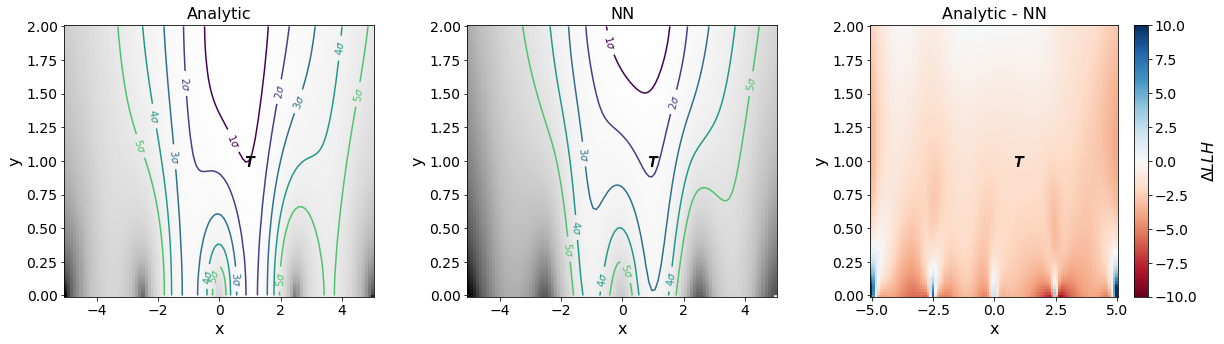

In [224]:
xxs = np.repeat(test_event[0][np.newaxis, :], np.prod(g.shape), axis=0)
xxs = xxs.reshape(-1, 7)

tts = np.repeat(truth[np.newaxis, :], np.prod(g.shape), axis=0)
tts[:, 0] = g.get_array('x', flat=True)
tts[:, 1] = g.get_array('y', flat=True)
tts = np.repeat(tts, len(test_event[0]), axis=0)

hmodel.layers[-1].activation = tf.keras.activations.linear
hmodel.compile()

llhs = -hmodel.predict((xxs, tts), batch_size=4096)

llhs = np.nan_to_num(np.sum(llhs.reshape(-1, len(test_event[0])), axis=1))

g.hit_llh = llhs.reshape(g.shape)

g.hit_llh -= g.hit_llh.min()

fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g.total_charge_hit_terms, g.hit_llh, title_a='Analytic', title_b='NN', vmax=10, axes=ax, limit_diff=True)
plot_truth(ax, truth)
#plt.savefig('hitNNtest.png', bbox_inches='tight')

## Charge Net

In [259]:
x, t = NNs.get_charge_data(events, truths)
x_train, x_test, t_train, t_test = train_test_split(x, t, test_size=0.1, random_state=42)

d_train = NNs.DataGenerator(x_train, t_train, batch_size=4096)
d_valid = NNs.DataGenerator(x_test, t_test, batch_size=4096)

In [260]:
optimizer = tf.keras.optimizers.Adam(1e-3)
cmodel = NNs.get_cmodel(x_shape=2, t_shape=8, trafo=NNs.charge_trafo, activation='swish')
cmodel.compile(loss='binary_crossentropy', optimizer=optimizer)

In [261]:
hist = cmodel.fit(d_train, epochs=200, verbose=1, validation_data=d_valid)

Epoch 1/200
43/43 [==============================] - 1s 15ms/step - loss: 0.7456 - val_loss: 0.6932
Epoch 2/200
43/43 [==============================] - 0s 9ms/step - loss: 0.6877 - val_loss: 0.6381
Epoch 3/200
43/43 [==============================] - 0s 8ms/step - loss: 0.5796 - val_loss: 0.5329
Epoch 4/200
43/43 [==============================] - 0s 8ms/step - loss: 0.5008 - val_loss: 0.4840
Epoch 5/200
43/43 [==============================] - 0s 8ms/step - loss: 0.4981 - val_loss: 0.4809
Epoch 6/200
43/43 [==============================] - 0s 8ms/step - loss: 0.6039 - val_loss: 0.5995
Epoch 7/200
43/43 [==============================] - 0s 9ms/step - loss: 0.5276 - val_loss: 0.4926
Epoch 8/200
43/43 [==============================] - 0s 9ms/step - loss: 0.4894 - val_loss: 0.4988
Epoch 9/200
43/43 [==============================] - 0s 9ms/step - loss: 0.5228 - val_loss: 0.6051
Epoch 10/200
43/43 [==============================] - 0s 8ms/step - loss: 0.5129 - val_loss: 0.5943
Epoch 11

43/43 [==============================] - 0s 9ms/step - loss: 0.3658 - val_loss: 0.3551
Epoch 84/200
43/43 [==============================] - 0s 9ms/step - loss: 0.4218 - val_loss: 0.4794
Epoch 85/200
43/43 [==============================] - 0s 9ms/step - loss: 0.4336 - val_loss: 0.3976
Epoch 86/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3858 - val_loss: 0.3774
Epoch 87/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3838 - val_loss: 0.3685
Epoch 88/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3735 - val_loss: 0.3661
Epoch 89/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3675 - val_loss: 0.3702
Epoch 90/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3635 - val_loss: 0.3652
Epoch 91/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3641 - val_loss: 0.3600
Epoch 92/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3930 - val_loss: 0.3812
Epoch 93/200


43/43 [==============================] - 0s 9ms/step - loss: 0.3487 - val_loss: 0.3480
Epoch 165/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3617 - val_loss: 0.3624
Epoch 166/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3469 - val_loss: 0.3552
Epoch 167/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3637 - val_loss: 0.3597
Epoch 168/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3458 - val_loss: 0.3478
Epoch 169/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3483 - val_loss: 0.3551
Epoch 170/200
43/43 [==============================] - 0s 8ms/step - loss: 0.3466 - val_loss: 0.3479
Epoch 171/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3529 - val_loss: 0.3676
Epoch 172/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3471 - val_loss: 0.3429
Epoch 173/200
43/43 [==============================] - 0s 9ms/step - loss: 0.3486 - val_loss: 0.3542
Epoc

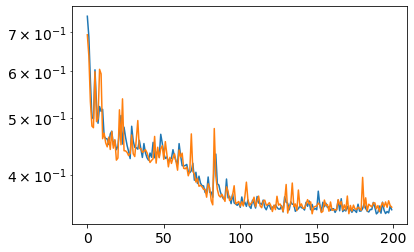

In [262]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

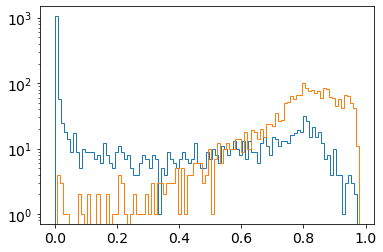

In [263]:
inp, lab = d_valid.__getitem__(0)
pred = cmodel.predict(inp, batch_size=4096).flatten()
plt.hist(pred[lab==0], 100, histtype='step')
plt.hist(pred[lab==1], 100, histtype='step');
plt.yscale('log')

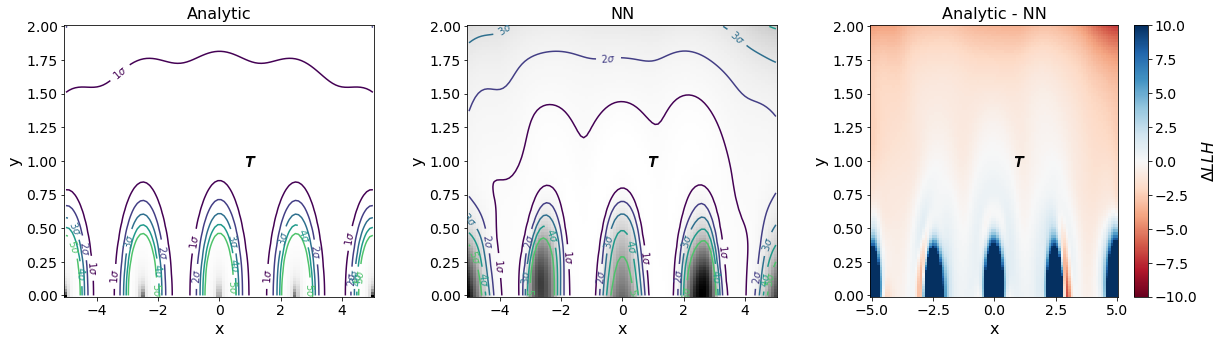

In [265]:
xxs = np.tile([len(test_event[0]), len(np.unique(test_event[0][:,0]))], np.prod(g.shape))
xxs = xxs.reshape(-1, 2)

tts = np.repeat(truth[np.newaxis, :], np.prod(g.shape), axis=0)
tts[:, 0] = g.get_array('x', flat=True)
tts[:, 1] = g.get_array('y', flat=True)

cmodel.layers[-1].activation = tf.keras.activations.linear
cmodel.compile()

llhs = np.nan_to_num(-cmodel.predict((xxs, tts), batch_size=4096))

g.total_charge_llh = llhs.reshape(g.shape)

g.total_charge_llh -= g.total_charge_llh.min()

fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g.total_charge_terms, g.total_charge_llh, title_a='Analytic', title_b='NN', vmax=10, axes=ax, limit_diff=True)
plot_truth(ax, truth)
#plt.savefig('chargeNNtest.png', bbox_inches='tight')

## ??

In [ ]:
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.x, hitnet.t, test_size=0.2, random_state=42)

In [ ]:
hitnet.d_train = get_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = get_dataset(hitnet.x_test, hitnet.t_test, test=True)

In [ ]:
hitnet.trafo = build_h_trafo(det_xs)

In [ ]:
activation='elu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0005)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [ ]:
hist = hitnet.model.fit(hitnet.d_train, epochs=10, verbose=1, validation_data=hitnet.d_test)

In [ ]:
plt.plot(hitnet.model.history.history['loss'])
plt.plot(hitnet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

In [ ]:
hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [ ]:
hitnet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
hitnet.tts = np.repeat(hitnet.tt, test_event[1].shape[0], axis=0)
hitnet.xxs = np.repeat(test_event[1][np.newaxis,:, :], np.prod(g.shape), axis=0)
hitnet.xxs = hitnet.xxs.reshape(-1, 3)

In [ ]:
hitnet.llhs = hitnet.llh.predict([hitnet.xxs, hitnet.tts])    

In [ ]:
g['hit_llh'] = -np.sum(hitnet.llhs.reshape(-1, test_event[1].shape[0]), axis=1).reshape(g.shape)
g['hit_llh'] -= np.min(g['hit_llh'])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['total_charge_hit_terms'], g['hit_llh'], title_a='Analytic', title_b='NN', 
          vmax=50, axes=ax, limit_diff=False)
plot_truth(ax, example_x_src, example_b_src)

In [ ]:
g['llh'] = g['charge_llh'] + g['hit_llh']
g['llh'] -= np.min(g['llh'])

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20,18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Zoom in
#grid_to_plot = g[example_x_src-0.5:example_x_src+0.5, example_b_src-0.5:example_b_src+0.5]

grid_to_plot = g

plot_diff(grid_to_plot['total_charge_hit_terms'], grid_to_plot['hit_llh'], 
          title_a='Hit Analytic', title_b='Hit NN', vmax=10, axes=ax[0], limit_diff=True)
plot_diff(grid_to_plot['total_charge_terms'], grid_to_plot['charge_llh'], 
          title_a='Charge Analytic', title_b='Charge NN', vmax=10, axes=ax[1], limit_diff=True)
plot_diff(grid_to_plot['total_charge_llh'], grid_to_plot['llh'], title_a='Analytic',
          title_b='NN', vmax=5, axes=ax[2], limit_diff=True)

plot_truth(ax, example_x_src, example_b_src)

#plt.savefig('NNtest.png', bbox_inches='tight')

### Save the models now

In [ ]:
chargenet.model.save('paper_toy_chargenet.h5')

In [ ]:
#chargenet = tf.keras.models.load_model('paper_toy_chargenet.h5', custom_objects=dict(q_trafo=build_q_trafo(toy_experiment.detector_xs)))
#hitnet = tf.keras.models.load_model('paper_toy_hitnet.h5', custom_objects=dict(h_trafo=build_h_trafo(toy_experiment.detector_xs)))

In [ ]:
hitnet.model.save('paper_toy_hitnet.h5')

In [ ]:
s = g[:,0.3]
#s = g[1.45]

fig, ax = plt.subplots(1,1, figsize=(12,8))

c2 = 'tab:blue'
c1 = 'tab:orange'
c3 = 'k' #tab:green'


#s.dom_hit_term.plot(c=c3, ls=':', label="Eq. 2 p-term")
#s.dom_charge_terms.plot(c=c3, ls='--', label="Eq. 2 N-term")
#s.dom_llh.plot(c=c3, label=r"Eq. 2 $\mathcal{L}$")


s.total_charge_hit_terms.plot(c=c1, ls='-', label="Eq. 4 p-term")
s.hit_llh.plot(c=c1, ls=':', label="NN Eq. 4 p-term")

s.total_charge_terms.plot(c=c2, ls='-', label="Eq. 4 N-term")
s.charge_llh.plot(c=c2, ls=':', label="NN Eq. 4 N-term")

s.total_charge_llh.plot(c=c3, ls='-', label=r"Eq. 4 $\mathcal{L}$")
s.llh.plot(c=c3, ls=':', label=r"NN Eq. 4 $\mathcal{L}$")


plt.legend()

ax.set_ylabel(r'$-\Delta\log{\mathcal{L}}$')

plt.gca().set_ylim(0, 100)

In [ ]:
s = g[:,0.3]
#s = g[1.45]

fig, ax = plt.subplots(1,1, figsize=(12,8))

c2 = 'tab:blue'
c1 = 'tab:orange'
c3 = 'k' #tab:green'



s.total_charge_hit_terms.plot(c=c1, ls='-', label="Eq. 4 p-term")
s.dom_hit_term.plot(c=c1, ls=':', label="Eq. 2 p-term")

s.total_charge_terms.plot(c=c2, ls='-', label="Eq. 4 N-term")
s.dom_charge_terms.plot(c=c2, ls=':', label="Eq. 2 N-term")

s.total_charge_llh.plot(c=c3, ls='-', label=r"Eq. 4 $\mathcal{L}$")
s.dom_llh.plot(c=c3, ls=':', label=r"Eq. 2 $\mathcal{L}$")



plt.legend()

ax.set_ylabel(r'$-\Delta\log{\mathcal{L}}$')

plt.gca().set_ylim(0, 100)